# Bank Clients Churn Prediction

Bank's clients start to leak every month. Not so much, but significantly. Market analysts found out that to save actual customers is cheaper than bring new ones. In this project we'll builld model to predict whether client is going to leave or not. In our possesion information about clients, their behavior and services they use.
To evaluate model performance we'll use f1 score and set it's treshold on 0.59. Additionaly we will calculate AUC-ROC metric. Then compare both.

source(https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Data Preprocessing

In [1]:
# load data and libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, recall_score, precision_score 
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
#data exploration
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
data.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
5599,5600,15635870,She,579,Germany,Female,50,5.0,117721.02,1,0,1,192146.63,1
3512,3513,15657779,Boylan,806,Spain,Male,18,3.0,0.00,2,1,1,86994.54,0
2548,2549,15617197,Chien,524,France,Male,50,4.0,0.00,2,1,1,31840.59,1
4542,4543,15585455,Stewart,630,France,Male,28,9.0,0.00,2,0,0,32599.35,0
2871,2872,15798824,Kennedy,671,Spain,Male,38,0.0,92674.94,2,1,0,3647.57,0
7937,7938,15775886,Su,670,France,Male,36,NaN,0.00,1,1,0,140754.19,1
3968,3969,15595657,Hannam,649,Germany,Male,40,4.0,95001.33,1,0,1,123202.99,0
26,27,15736816,Young,756,Germany,Male,36,2.0,136815.64,1,1,1,170041.95,0
2893,2894,15719606,Rivers,657,France,Male,50,9.0,0.00,2,0,0,37171.46,0
2085,2086,15687477,Thompson,594,Germany,Male,28,5.0,185013.02,1,1,0,16481.12,0


In [6]:
# check multicollinearity
data.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


### Conclusion

After data exploration we can say following:
- column RowNumber duplicates index, we can drop it
- column names contain capital latters - convert them to lower case
- we don't need last names and id's of clients - drop them
- tenure column has missing values - about 10% - try to recover them.
- gender and geography columns are object - its better to convert them to numeric via one hot encoding method



In [7]:
#convert to lower case
data.columns = data.columns.str.lower()

In [8]:
#drop rownumber, customerid, surname
data = data.drop(['rownumber', 'customerid', 'surname'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             9091 non-null float64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [9]:
# fill missing values with data goruped by age and geography 
data['tenure'] = data['tenure'].fillna(data.groupby(by=['age', 'geography'])['tenure'].transform('median'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             10000 non-null float64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [10]:
# encode object data
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
creditscore          10000 non-null int64
age                  10000 non-null int64
tenure               10000 non-null float64
balance              10000 non-null float64
numofproducts        10000 non-null int64
hascrcard            10000 non-null int64
isactivemember       10000 non-null int64
estimatedsalary      10000 non-null float64
exited               10000 non-null int64
geography_Germany    10000 non-null uint8
geography_Spain      10000 non-null uint8
gender_Male          10000 non-null uint8
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


### Conclusion

After data preprocessing:
- column names converted to lower case
- columns rownumber, customerid, surname have dropped
- filled missing values in tenure column              
- object columns gender, geography converted to numeric

## Machine Learning

In [11]:
#check imbalance of classes
data_ohe['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

### Conclusion

Distinguished skew toward 0

Learn model on the data as it is

In [12]:
# brake data off on train, valid and test
train_valid, test = train_test_split(data_ohe, test_size=0.2, random_state=12345)
train, valid = train_test_split(train_valid, test_size=0.25, random_state=12345)

features_train = train.drop('exited', axis=1)
target_train = train['exited']

features_valid = valid.drop('exited', axis=1)
target_valid = valid['exited']

features_test = test.drop('exited', axis=1)
target_test = test['exited']

#check samples sizes
samples = [train, valid, test]
for sample in samples:
    print(sample.shape)

(6000, 12)
(2000, 12)
(2000, 12)


In [13]:
#scalar features
numeric = features_train.columns.values

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None
features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
492,-0.134048,-0.078068,-0.367882,0.076163,0.816929,-1.550255,0.968496,0.331571,-0.579146,-0.576837,-1.103311
6655,-1.010798,0.494555,-0.007390,0.136391,-0.896909,0.645055,0.968496,-0.727858,-0.579146,-0.576837,0.906363
4287,0.639554,1.353490,-1.449359,0.358435,-0.896909,0.645055,0.968496,-0.477006,1.726679,-0.576837,0.906363
42,-0.990168,2.116987,-1.088866,0.651725,-0.896909,0.645055,0.968496,-0.100232,-0.579146,-0.576837,-1.103311
8178,0.567351,0.685430,0.713594,0.813110,0.816929,0.645055,0.968496,0.801922,-0.579146,-0.576837,-1.103311


In [14]:
#learn a RandomForest model and find optimal hyperparameters
rf = RandomForestClassifier(random_state=12345) 
distributions = dict(n_estimators=[1, 80], max_depth=[1, 7], criterion = ['gini', 'entropy'])

clf = RandomizedSearchCV(rf, distributions, random_state=12345)
search = clf.fit(features_train, target_train)

print('Best hyperparametres', search.best_params_)

best_n_estimators = search.best_params_['n_estimators']
best_max_depth = search.best_params_['max_depth']
best_criterion = search.best_params_['criterion']

Best hyperparametres {'n_estimators': 80, 'max_depth': 7, 'criterion': 'gini'}


In [15]:
#learn a RandomForest model with optimal hyperparameters

rf = RandomForestClassifier(random_state=12345, 
                n_estimators=best_n_estimators,
                max_depth=best_max_depth,
                criterion=best_criterion) 

rf.fit(features_train, target_train)
predicted_valid = rf.predict(features_valid)
rf_result = f1_score(target_valid, predicted_valid)
  
print("F1_score of the best model:", rf_result)

F1_score of the best model: 0.5214408233276158


In [16]:
#do the same with a LogisticRegression model
lr = LogisticRegression(random_state=12345, penalty = 'l2')
distributions = dict(solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                     C = [100, 10, 1.0, 0.1, 0.01, 0.001],
                    )

clf = RandomizedSearchCV(lr, distributions, random_state=12345)
search = clf.fit(features_train, target_train)

print('Best hyperparametres', search.best_params_)

best_solver = search.best_params_['solver']
best_C = search.best_params_['C']


Best hyperparametres {'solver': 'saga', 'C': 0.01}


In [17]:
#learn a LogisticRegression model with optimal hyperparameters
def Learn_LogisticRegression(features_train, target_train, features_valid, target_valid, class_weight):
    lr = LogisticRegression(solver=best_solver, C=best_C, random_state=12345, class_weight=class_weight) 

    lr.fit(features_train, target_train)

    predicted_valid = lr.predict(features_valid)
    lr_result = f1_score(target_valid, predicted_valid)
    return lr_result

lr_result = Learn_LogisticRegression(features_train, target_train, features_valid, target_valid, None)
print("F1_score of the best model:", lr_result)

F1_score of the best model: 0.24193548387096778


                        F1_score
best_forest_result      0.521441
best_regression_result  0.241935


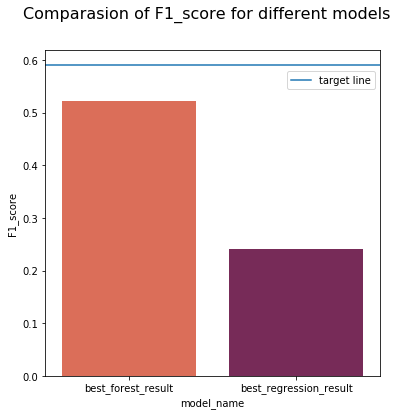

In [18]:
#compare results on validation dataset
def show_results(rf_result, lr_result):
    results = pd.DataFrame({'F1_score' : [rf_result, lr_result]}, 
                           index = ['best_forest_result', 'best_regression_result'])

    print(results)

    plt.figure(figsize=(6,6))
    sns.barplot(x= results.index, y=results['F1_score'], palette="rocket_r")
    plt.suptitle('Comparasion of F1_score for different models', fontsize=16)
    plt.xlabel('model_name')
    plt.ylabel('F1_score')
    plt.axhline(0.59, label='target line')
    plt.legend(loc="higher right", bbox_to_anchor=(0.5, 0.45, 0.5, 0.5))
    plt.show()
    
show_results(rf_result, lr_result)

### Conclusion

Couse of a strong imbalance f1 score of both models is less than we expected (0.59). Let's try few ways to improve it.  


## Classes Balance Improvement

May be class weighting can help us

In [19]:
#RandomForest at first
rf = RandomForestClassifier(random_state=12345, 
                            n_estimators=best_n_estimators,
                           max_depth=best_max_depth,
                           criterion=best_criterion,
                            class_weight='balanced') 

rf.fit(features_train, target_train)
predicted_valid = rf.predict(features_valid)
rf_result_balanced = f1_score(target_valid, predicted_valid)

print("F1_score of balanced model:", rf_result_balanced)

F1_score of balanced model: 0.5821389195148842


In [20]:
#then LogisticRegression
lr = LogisticRegression(
    random_state=12345, solver=best_solver, 
    C=best_C,
    class_weight='balanced') 

lr.fit(features_train, target_train)

predicted_valid = lr.predict(features_valid)
lr_result_balanced = f1_score(target_valid, predicted_valid)

print("F1_score of balanced model:", lr_result_balanced)

F1_score of balanced model: 0.4741532976827095


                        F1_score
best_forest_result      0.582139
best_regression_result  0.474153


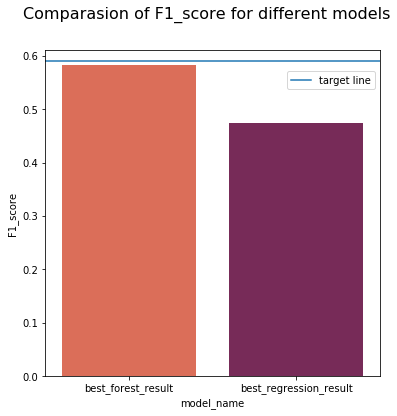

In [21]:
show_results(rf_result_balanced, lr_result_balanced)

### Conclusion

After class weighting F1_score has increased and with RandomForest almost hit the target.
Go try another way.

Features upsampling

In [22]:
#upsampling function
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 2)

In [23]:
#RandomForest
rf = RandomForestClassifier(random_state=12345, 
                            n_estimators=best_n_estimators,
                           max_depth=best_max_depth,
                           criterion=best_criterion) 

rf.fit(features_upsampled, target_upsampled)
predicted_valid = rf.predict(features_valid)
rf_result_upsampled = f1_score(target_valid, predicted_valid)
best_rf = rf

print("F1_score of model on upsampled features:", rf_result_upsampled)

F1_score of model on upsampled features: 0.6051873198847263


In [24]:
#LogisticRegression
lr = LogisticRegression(
    random_state=12345, solver=best_solver, 
    C=best_C) 

lr.fit(features_upsampled, target_upsampled)

predicted_valid = lr.predict(features_valid)
lr_result_upsampled = f1_score(target_valid, predicted_valid)

print("F1_score of model on upsampled features:", lr_result_upsampled)

F1_score of model on upsampled features: 0.4808743169398907


                        F1_score
best_forest_result      0.605187
best_regression_result  0.480874


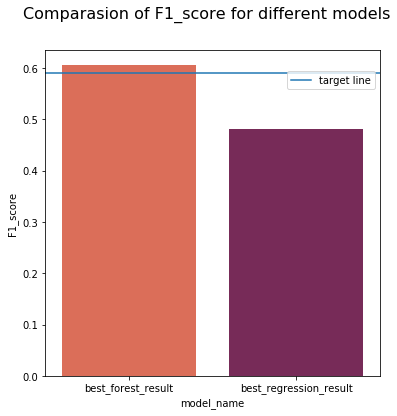

In [25]:
show_results(rf_result_upsampled, lr_result_upsampled)

### Conclusion

Features upsampling distinctly improved model performance. So RandomForest model hit the target.

Features downsampling

In [26]:
#downsampling function
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.5)

In [27]:
#RandomForest
rf = RandomForestClassifier(random_state=12345, 
                            n_estimators=best_n_estimators,
                           max_depth=best_max_depth,
                           criterion=best_criterion) 

rf.fit(features_downsampled, target_downsampled)
predicted_valid = rf.predict(features_valid)
rf_result_downsampled = f1_score(target_valid, predicted_valid)

print("F1_score of model on downsampled features:", rf_result_downsampled)

F1_score of model on downsampled features: 0.5931232091690544


In [28]:
#затем LogisticRegression
lr = LogisticRegression(
    random_state=12345, solver=best_solver, 
    C=best_C) 

lr.fit(features_downsampled, target_downsampled)

predicted_valid = lr.predict(features_valid)
lr_result_downsampled = f1_score(target_valid, predicted_valid)

print("F1_score of model on downsampled features:", lr_result_downsampled)

F1_score of model on downsampled features: 0.4725274725274725


                        F1_score
best_forest_result      0.593123
best_regression_result  0.472527


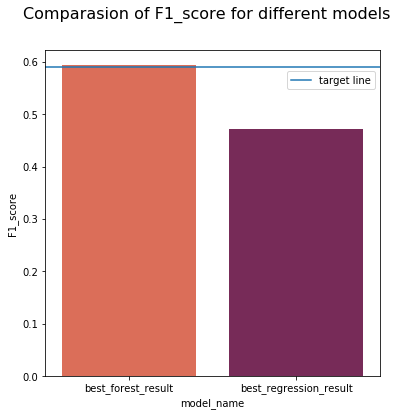

In [29]:
show_results(rf_result_downsampled, lr_result_downsampled)

### Conclusion

Features downsampling has helped to increase the metric, but less then upsampling. Goal is accomplished anyway. 

Classification treshold adjusting


In [30]:
# let's try to get up a treshold and fit the best LogisticRegression model with upsampling and class weighting 

lr = LogisticRegression(
    random_state=12345, solver=best_solver, 
    C=best_C,
    class_weight='balanced') 

lr.fit(features_upsampled, target_upsampled)

probabilities_one_valid = lr.predict_proba(features_valid)[:, 1]

lr_result_adjusted = 0
for threshold in np.arange(0.5, 0.75, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    lr_result_threshold = f1_score(target_valid, predicted_valid)
    if lr_result_threshold > lr_result_adjusted:
        lr_result_adjusted = lr_result_threshold
        threshold_adjusted = threshold

print("F1_score model with a greater classification treshold:", lr_result_adjusted)
print("Best threshold:", threshold_adjusted)

F1_score model with a greater classification treshold: 0.49196538936959205
Best threshold: 0.6200000000000001


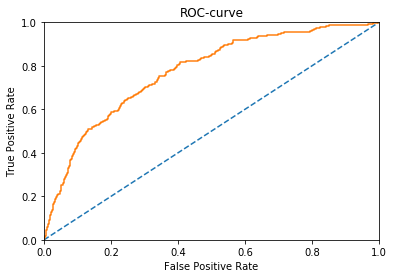

AUC_ROC = 0.7721114765251089


In [31]:
# plot the ROC curve
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-curve')
plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC_ROC =', auc_roc)

In [32]:
# do the same with ''standard'' model, but lesser classification treshold
lr = LogisticRegression(
    random_state=12345, solver=best_solver, 
    C=best_C) 

lr.fit(features_train, target_train)

probabilities_one_valid = lr.predict_proba(features_valid)[:, 1]

lr_result_adjusted = 0
for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    lr_result_threshold = f1_score(target_valid, predicted_valid)
    if lr_result_threshold > lr_result_adjusted:
        lr_result_adjusted = lr_result_threshold
        threshold_adjusted = threshold

print("F1_score model with a lesser classification treshold:", lr_result_adjusted)
print("Best threshold:", threshold_adjusted)

F1_score model with a lesser classification treshold: 0.4874371859296482
Best threshold: 0.3


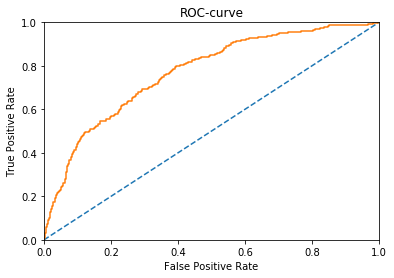

AUC_ROC = 0.7699624395384657


In [33]:
# plot the ROC curve
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-curve')
plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC_ROC =', auc_roc)

### Conclusion

Class balancing and upsampling helps to improve performance of Logistic Regression model. On ROC curve figure we can see that model shows good enough true positive ratio at not so great fals positive ratio. But f1 score don't muches given requirement.

## Model Testing

In [34]:
#check the best model fitted on train+valid on test dataset
features_train_valid = train_valid.drop('exited', axis=1)
target_train_valid = train_valid['exited']

best_rf.fit(features_train_valid, target_train_valid)
predicted_valid = rf.predict(features_test)
rf_result_upsampled = f1_score(target_test, predicted_valid)

print("F1_score of model with upsampling:", rf_result_upsampled)
print("Recall of model with upsampling:", recall_score(target_test, predicted_valid))
print("Precision of model with upsampling:", precision_score(target_test, predicted_valid))

F1_score of model with upsampling: 0.6120358514724712
Recall of model with upsampling: 0.5597189695550351
Precision of model with upsampling: 0.6751412429378532


                        F1_score
best_forest_result      0.612036
best_regression_result       NaN


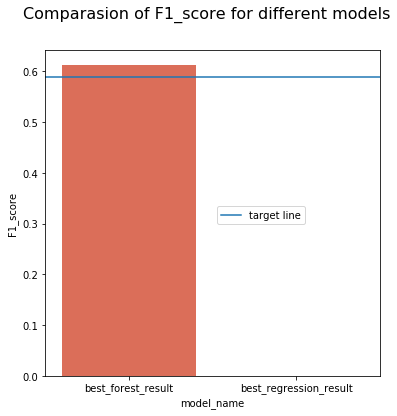

In [35]:
show_results(rf_result_upsampled, None)

Text(0, 0.5, 'Mean decrease in impurity')

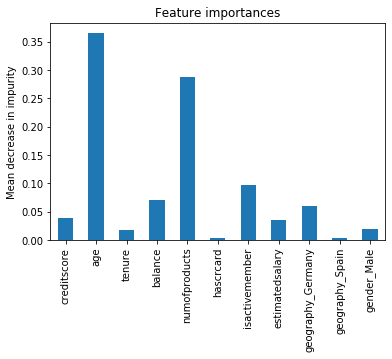

In [36]:
#have a look at the features importance
importances = best_rf.feature_importances_
forest_importances = pd.Series(importances, index=features_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')


### Conclusion

Model performance has approved on test dataset. Increasing of max_depth parameter should improve model performance but might lead to overfitting.

## General Conclusion

In this project we 've built the model to predict bank clients churn. F1 score muches given requirements (0.59). It appears that the most influence features are age and num_of_products.